# Classifier

Tasks:
1. Load training data from data/train/
2. Load CNN pre-trained model- ResNet50
3. Train CNN model
4. Saved trained model in models/

# Requirements

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import collections

# Mount Project

In [0]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Required Paths
1. Dataset required to train (/data/train/)
2. Models (/models/)

In [0]:
PARENT_DIR = "/content/gdrive/My Drive/projects/infographics_dataset_collection"
DATA_DIR = PARENT_DIR + "/data/train"
MODEL_PATH = PARENT_DIR + "/models/infographics_classifier_v2.pth"
BATCH_SIZE = 16

# Preprocess

1. Resizing to 256
2. Center crop to 224
3. Normalization

# Split Data - Train, Test

TODO - batch_size = 1, hotfix for (stack requires tensors to be of equal size). CHANGE.

In [0]:
def load_split_train_test(datadir, valid_size = .2):
    preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])
    # train_transforms = transforms.Compose([transforms.Resize(224),
    #                                    transforms.ToTensor(),
    #                                    ])
    # test_transforms = transforms.Compose([transforms.Resize(224),
    #                                   transforms.ToTensor(),
    #                                   ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=preprocess)
    test_data = datasets.ImageFolder(datadir,
                    transform=preprocess)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=BATCH_SIZE)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=BATCH_SIZE)
    return trainloader, testloader
trainloader, testloader = load_split_train_test(DATA_DIR, .2)
print(trainloader.dataset.classes)

['info', 'notinfo']


# Model - Load, Setup

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
model = models.resnet50(pretrained=True) 

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


In [0]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Training

In [0]:
epochs = 3
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device),labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/3.. Train loss: 2.429.. Test loss: 0.883.. Test accuracy: 0.677
Epoch 1/3.. Train loss: 2.908.. Test loss: 0.495.. Test accuracy: 0.792


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/3.. Train loss: 1.441.. Test loss: 0.755.. Test accuracy: 0.740
Epoch 1/3.. Train loss: 0.421.. Test loss: 0.419.. Test accuracy: 0.807
Epoch 2/3.. Train loss: 0.614.. Test loss: 0.528.. Test accuracy: 0.734
Epoch 2/3.. Train loss: 0.568.. Test loss: 0.337.. Test accuracy: 0.849
Epoch 2/3.. Train loss: 0.371.. Test loss: 0.351.. Test accuracy: 0.854
Epoch 2/3.. Train loss: 0.351.. Test loss: 0.321.. Test accuracy: 0.875
Epoch 2/3.. Train loss: 0.518.. Test loss: 0.380.. Test accuracy: 0.839
Epoch 3/3.. Train loss: 0.425.. Test loss: 0.340.. Test accuracy: 0.870
Epoch 3/3.. Train loss: 0.435.. Test loss: 0.362.. Test accuracy: 0.854
Epoch 3/3.. Train loss: 0.379.. Test loss: 0.397.. Test accuracy: 0.818
Epoch 3/3.. Train loss: 0.408.. Test loss: 0.367.. Test accuracy: 0.828
Epoch 3/3.. Train loss: 0.408.. Test loss: 0.322.. Test accuracy: 0.859


# Save Model

In [0]:
torch.save(model, MODEL_PATH)

# Analysis - Loss

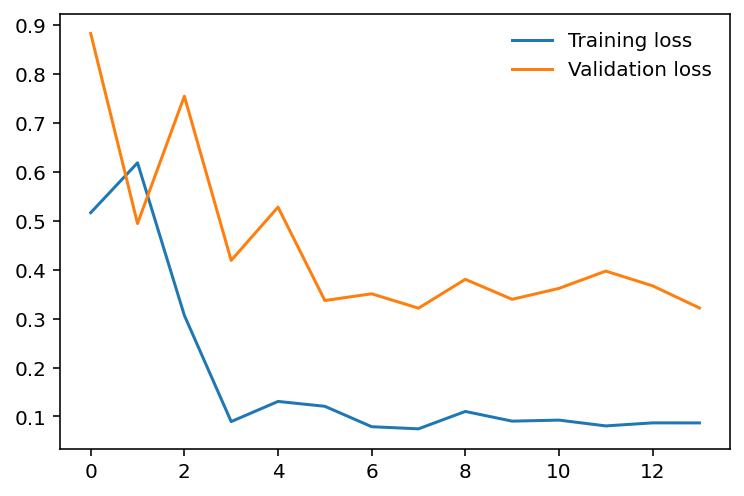

In [0]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

![Epoch results](https://drive.google.com/uc?id=1k_6m1LdELczLs0aOd0cA2-S9d1dHYFMZ)